In [1]:
import pandas as pd 
import numpy as np

In [8]:

# помимо стандартных библиотек мы также импортируем библиотеку warnings
# она позволит скрыть предупреждения об ошибках
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
 
# кроме того, импортируем датасеты библиотеки sklearn
from sklearn import datasets
# а также функции для расчета метрики accuracy и построения матрицы ошибок
from sklearn.metrics import accuracy_score, confusion_matrix
 
# построенные нами модели мы будем сравнивать с результатом
# класса LogisticRegression библиотеки sklearn
from sklearn.linear_model import LogisticRegression
 
# среди прочего, мы построим модели полиномиальной логистической регрессии
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.DataFrame({'flavanoids': [1,2,3,2,3], 'proline':[10,20,30,20,12], 'target':[0,1,2,2,0]})
df.head()

,flavanoids,proline,target
0,1,10,0
1,2,20,1
2,3,30,2
3,2,20,2
4,3,12,0


In [3]:
df.target.value_counts()

0    2
2    2
1    1
Name: target, dtype: int64

In [4]:
def correlation_ratio(numerical, categorical):
 
    values = np.array(numerical)
    ss_total = np.sum((values.mean() - values) ** 2)
 
    cats = np.unique(categorical, return_inverse = True)[1]
    ss_betweengroups = 0
 
    for c in np.unique(cats):
 
        group = values[np.argwhere(cats == c).flatten()]
        ss_betweengroups += len(group) * (group.mean() - values.mean()) ** 2
 
    return np.sqrt(ss_betweengroups/ss_total)

In [5]:
# создадим два списка, один для названий признаков, второй для значений корреляционного отношения
columns, correlations = [], []
 
# пройдемся по всем столбцам датафрейма кроме целевой переменной
for col in df.drop('target', axis = 1).columns:
  # поместим название признака в список columns
    columns.append(col)
  # рассчитаем взаимосвязь этого признака с целевой переменной
  # и поместим результат в список значений корреляционного отношения
    correlations.append(correlation_ratio(df[col], df['target']))

# создадим датафрейм на основе заполненных списков
# и применим градиентную цветовую схему
pd.DataFrame({'column': columns, 'correlation': correlations}).style.background_gradient()


,column,correlation
0,flavanoids,0.327327
1,proline,0.890502


In [6]:
df = df[['flavanoids', 'proline', 'target']].copy()
df.head(3)

,flavanoids,proline,target
0,1,10,0
1,2,20,1
2,3,30,2


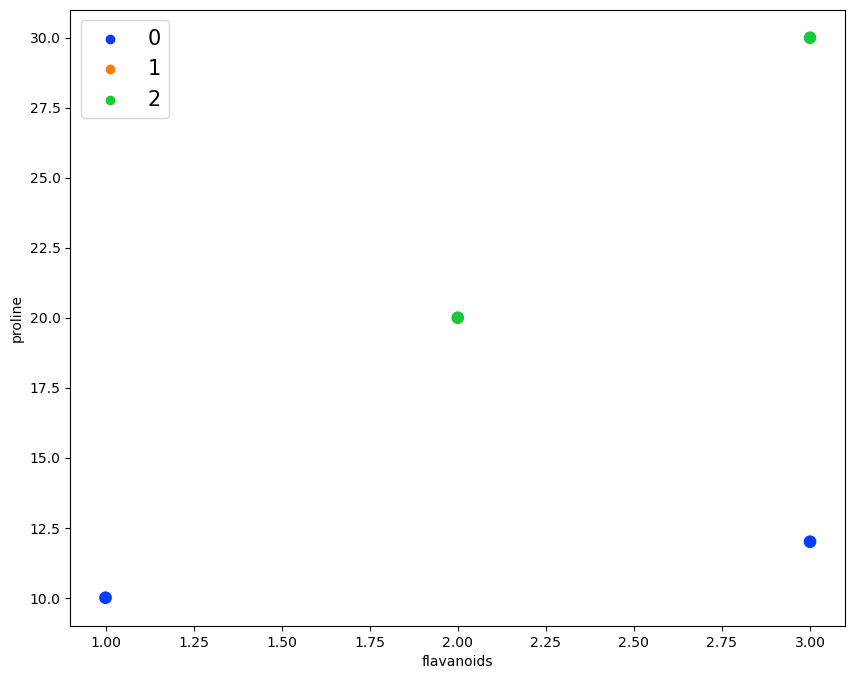

In [9]:
# зададим размер графика
plt.figure(figsize = (10, 8))
# построим точечную диаграмму с двумя признаками, разделяющей категориальной переменной будет класс вина
sns.scatterplot(x = df.flavanoids, y = df.proline, hue = df.target, palette = 'bright', s = 100)
# добавим легенду
plt.legend(loc = 'upper left', prop = {'size': 15})
plt.show()

In [10]:
# поместим признаки и данные в соответствующие переменные
x1, x2 = df.columns[0], df.columns[1]
 
target = df.target.unique()
target

array([0, 1, 2], dtype=int64)

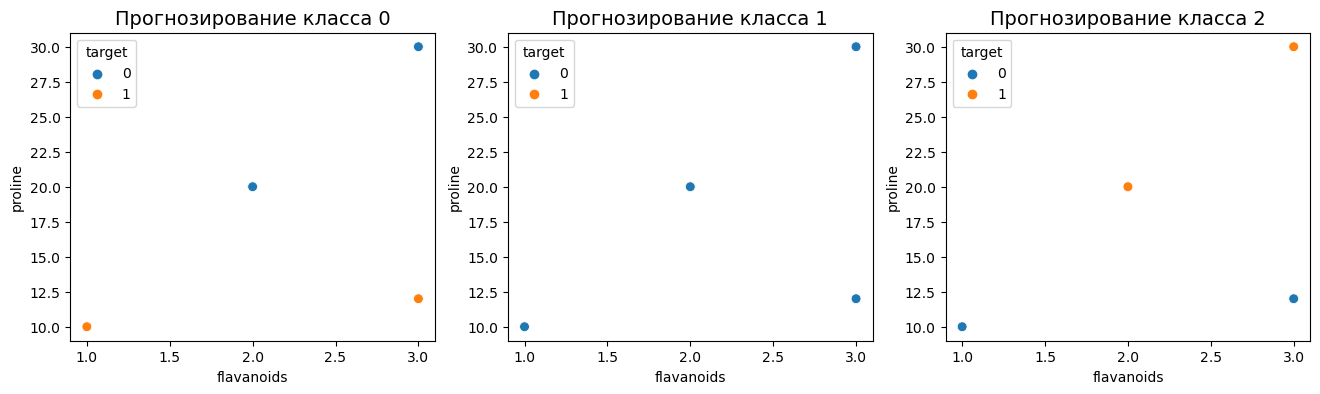

In [11]:
# сделаем копии датафреймов
ovr_0, ovr_1, ovr_2 = df.copy(), df.copy(), df.copy()
 
# в каждом из них сделаем целевым классом 0-й, 1-й или 2-й классы
# например, в ovr_0 первым классом будет класс 0, а классы 1 и 2 - нулевым
ovr_0['target'] = np.where(df['target'] == target[0], 1, 0)
ovr_1['target'] = np.where(df['target'] == target[1], 1, 0)
ovr_2['target'] = np.where(df['target'] == target[2], 1, 0)
 
# выведем разделение на классы на графике
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, 
                                    figsize = (16, 4),
                                    gridspec_kw = {'wspace': 0.2, 'hspace': 0.08})
 
sns.scatterplot(data = ovr_0, x = x1, y = x2, hue = 'target', s = 50, ax = ax1)
ax1.set_title('Прогнозирование класса 0', fontsize = 14)
 
sns.scatterplot(data = ovr_1, x = x1, y = x2, hue = 'target', s = 50, ax = ax2)
ax2.set_title('Прогнозирование класса 1', fontsize = 14)
 
sns.scatterplot(data = ovr_2, x = x1, y = x2, hue = 'target', s = 50, ax = ax3)
ax3.set_title('Прогнозирование класса 2', fontsize = 14)
 
plt.show()


In [15]:
class LogReg():
 
  # в методе .__init__() объявим переменные для весов и уровня ошибки
    def __init__(self):
        self.thetas = None
        self.loss_history = []
 
  # метод .fit() необходим для обучения модели
  # этому методу мы передадим признаки и целевую переменную
  # кроме того, мы зададим значения по умолчанию
  # для количества итераций и скорости обучения
    def fit(self, x, y, iter = 20000, learning_rate = 0.001):
 
    # метод создаст "правильные" копии датафрейма
        x, y = x.copy(), y.copy()
 
    # добавит столбец из единиц
        self.add_ones(x)
 
    # инициализирует веса и запишет в переменную n количество наблюдений
        thetas, n = np.zeros(x.shape[1]), x.shape[0]
 
    # создадим список для записи уровня ошибки
        loss_history = []
 
    # в цикле равном количеству итераций
        for i in range(iter):
      # метод сделает прогноз с текущими весами
            y_pred = self.h(x, thetas)
      # найдет и запишет уровень ошибки
            loss_history.append(self.objective(y, y_pred))
      # рассчитает градиент
            grad = self.gradient(x, y, y_pred, n)
      # и обновит веса
            thetas -= learning_rate * grad
 
      # метод выдаст веса и список с историей ошибок
            self.thetas = thetas
            self.loss_history = loss_history
 
  # метод .predict() делает прогноз с помощью обученной модели
    def predict(self, x):
 
    # метод создаст "правильную" копию модели
        x = x.copy()
    # добавит столбец из единиц
        self.add_ones(x)
    # рассчитает значения линейной функции
        z = np.dot(x, self.thetas)
    # передаст эти значения в сигмоиду
        probs = np.array([self.stable_sigmoid(value) for value in z])
    # выдаст принадлежность к определенному классу и соответствующую вероятность
        return np.where(probs >= 0.5, 1, 0), probs
 
  # ниже приводятся служебные методы, смысл которых был разобран ранее
    def add_ones(self, x):
        return x.insert(0,'x0', np.ones(x.shape[0]))
 
    def h(self, x, thetas):
        z = np.dot(x, thetas)
        return np.array([self.stable_sigmoid(value) for value in z])
 
    def objective(self, y, y_pred):
        y_one_loss = y * np.log(y_pred + 1e-9)
        y_zero_loss = (1 - y) * np.log(1 - y_pred + 1e-9)
        return -np.mean(y_zero_loss + y_one_loss)
 
    def gradient(self, x, y, y_pred, n):
        return np.dot(x.T, (y_pred - y)) / n
 
    def stable_sigmoid(self, z):
        if z >= 0:
            return 1 / (1 + np.exp(-z))
        else:
            return np.exp(z) / (np.exp(z) + 1)

In [16]:
models = []
 
# поочередно обучим каждую из моделей
for ova_n in [ovr_0, ovr_1, ovr_2]:
    X = ova_n[['flavanoids', 'proline']]
    y = ova_n['target']
 
    model = LogReg()
    model.fit(X, y)
 
  # каждую обученную модель поместим в список
    models.append(model)

In [18]:
# вновь перенесем данные из исходного датафрейма
X = df[['flavanoids', 'proline']]
y = df['target']
 
# в список probs будем записывать результат каждой модели
# для каждого наблюдения
probs = []
 
for model in models:
    am, prob = model.predict(X)
    probs.append(prob)

In [19]:

# очевидно, для каждого наблюдения у нас будет три вероятности
# принадлежности к целевому классу
probs[0][0], probs[1][0], probs[2][0]

(0.4738854636402894, 0.3088120530641252, 0.3288669040404029)